# Userguide for the opern-source library SPFlow

SPFlow is an open-source functional-oriented Python package for Probabilistic Circuits (PCs) with ready-to-use implementations for Sum-Product Networks (SPNs). PCs are a class of powerful deep probabilistic models - expressible as directed acyclic graphs - that allow for tractable querying. This library provides routines for creating, learning, manipulating and interacting with PCs and is highly extensible and customizable.

## Create Toy Dataset

To demonstrate and visualize the main features of the library, we first create a 2D toy dataset with three Gaussian clusters, corresponding to labels 0, 1, and 2.
Each class contains 500 data points, for a total of 1,500 data points.

Dataset successfully created.
Shape of dataset: torch.Size([1500, 2])
Shape of labels: torch.Size([1500])
First 5 samples:
tensor([[-3.7504, -1.6473],
        [-0.0877,  1.9809],
        [ 3.1567, -2.6842],
        [ 2.2392, -0.7164],
        [ 0.3779,  3.9130]])
Corresponding labels:
tensor([1, 0, 2, 2, 0])


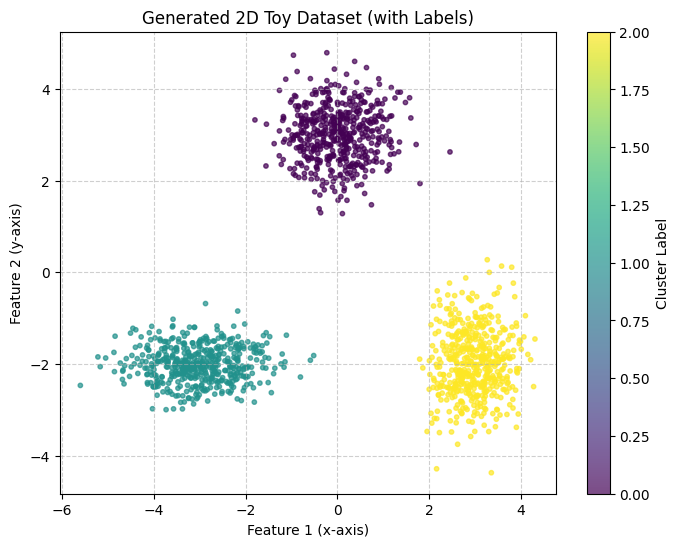

In [1]:
import torch
import matplotlib.pyplot as plt

# --- 1. Define the parameters for our dataset ---

n_points_per_cluster = 500

means = torch.tensor([
    [0.0, 3.0],   # Cluster 0
    [-3.0, -2.0], # Cluster 1
    [3.0, -2.0]   # Cluster 2
])

stds = torch.tensor([
    [0.6, 0.6],
    [0.8, 0.4],
    [0.5, 0.7]
])

# --- 2. Generate the data and labels ---

all_clusters = []
all_labels = []

for i in range(means.shape[0]):
    samples = (torch.randn(n_points_per_cluster, 2) * stds[i]) + means[i]
    labels = torch.full((n_points_per_cluster,), i, dtype=torch.long)  # label = cluster index
    all_clusters.append(samples)
    all_labels.append(labels)

# Concatenate all data and labels
dataset = torch.cat(all_clusters)
labels = torch.cat(all_labels)

# --- 3. Shuffle dataset and labels together ---

shuffled_indices = torch.randperm(dataset.shape[0])
dataset = dataset[shuffled_indices]
labels = labels[shuffled_indices]

# --- 4. Display some info ---

print("Dataset successfully created.")
print(f"Shape of dataset: {dataset.shape}")
print(f"Shape of labels: {labels.shape}")
print("First 5 samples:")
print(dataset[:5])
print("Corresponding labels:")
print(labels[:5])

# --- 5. Visualize the labeled dataset ---

data_np = dataset.cpu().numpy()
labels_np = labels.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(data_np[:, 0], data_np[:, 1], c=labels_np, cmap='viridis', s=10, alpha=0.7)
plt.title('Generated 2D Toy Dataset (with Labels)')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.colorbar(label='Cluster Label')
plt.show()



## Model Configuration
Below we manually create a simple Sum-Product Network by stacking leaf, product, and sum-layers

In [2]:
from spflow.modules.leaf import Normal
from spflow.modules import Sum
from spflow.modules import Product
from spflow.meta.data import Scope
from IPython.display import SVG, display

scope = Scope([0,1])

leaf_layer = Normal(scope=scope, out_channels=6)
product_layer = Product(inputs=leaf_layer)
spn = Sum(inputs=product_layer, out_channels=1)
spn

Sum(
  D=1, C=1, R=None, weights=(1, 6, 1)
  (inputs): Product(
    D=1, C=6, R=None
    (inputs): Normal(
      D=2, C=6, R=None
      (distribution): Normal()
    )
  )
)

Below is a visualization of the SPN defined above.
The number of output channels of a sum or leaf layer is equivalent to the number of nodes in that layer.
The number of nodes in a product layer is derived from the number of nodes in its input.

In [3]:
display(SVG(filename='StandardSPN.svg'))

Next, we can train the SPN, for example, using gradient descent.
The library already provides a method for training an SPN with gradient descent.
To do this, simply pass your training parameters such as the number of epochs, learning rate, etc.

In [4]:
from spflow.learn import train_gradient_descent
from torch.utils.data import DataLoader, TensorDataset
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s"
)

train_dataset = TensorDataset(dataset)
dataloader = DataLoader(train_dataset, batch_size=10)
train_gradient_descent(spn, dataloader, epochs=10, lr=0.1, verbose=True)

2025-10-16 16:20:43,294 [INFO] spflow.learn.gradient_descent: Epoch [0/10]: Loss: 30.496829986572266


Time taken for epoch:  0.4589977264404297


2025-10-16 16:20:43,707 [INFO] spflow.learn.gradient_descent: Epoch [1/10]: Loss: 30.97805404663086


Time taken for epoch:  0.41199779510498047


2025-10-16 16:20:44,137 [INFO] spflow.learn.gradient_descent: Epoch [2/10]: Loss: 30.288402557373047


Time taken for epoch:  0.4269988536834717


2025-10-16 16:20:44,631 [INFO] spflow.learn.gradient_descent: Epoch [3/10]: Loss: 30.86102294921875


Time taken for epoch:  0.4920005798339844


2025-10-16 16:20:45,055 [INFO] spflow.learn.gradient_descent: Epoch [4/10]: Loss: 30.259952545166016


Time taken for epoch:  0.42200136184692383


2025-10-16 16:20:45,479 [INFO] spflow.learn.gradient_descent: Epoch [5/10]: Loss: 30.059139251708984


Time taken for epoch:  0.4219982624053955


2025-10-16 16:20:45,949 [INFO] spflow.learn.gradient_descent: Epoch [6/10]: Loss: 30.052806854248047


Time taken for epoch:  0.46831631660461426


2025-10-16 16:20:46,415 [INFO] spflow.learn.gradient_descent: Epoch [7/10]: Loss: 30.04439353942871


Time taken for epoch:  0.46399784088134766


2025-10-16 16:20:46,862 [INFO] spflow.learn.gradient_descent: Epoch [8/10]: Loss: 30.05408477783203


Time taken for epoch:  0.4440004825592041


2025-10-16 16:20:47,388 [INFO] spflow.learn.gradient_descent: Epoch [9/10]: Loss: 30.066076278686523


Time taken for epoch:  0.524045467376709


Once the SPN is trained, we can perform queries such as inference and sampling.
SPFlow uses internal dispatching so that a single query function can work across all module types.
For example, the log_likelihood method shown below can be used for every SPN model encountered throughout this guide.

In [5]:
from spflow import log_likelihood

ll = log_likelihood(spn, dataset)
ll

tensor([[[-2.5693]],

        [[-3.3905]],

        [[-2.4838]],

        ...,

        [[-2.3321]],

        [[-1.9287]],

        [[-1.9782]]], grad_fn=<ViewBackward0>)

Finally, we can visualize the training results on our toy dataset.

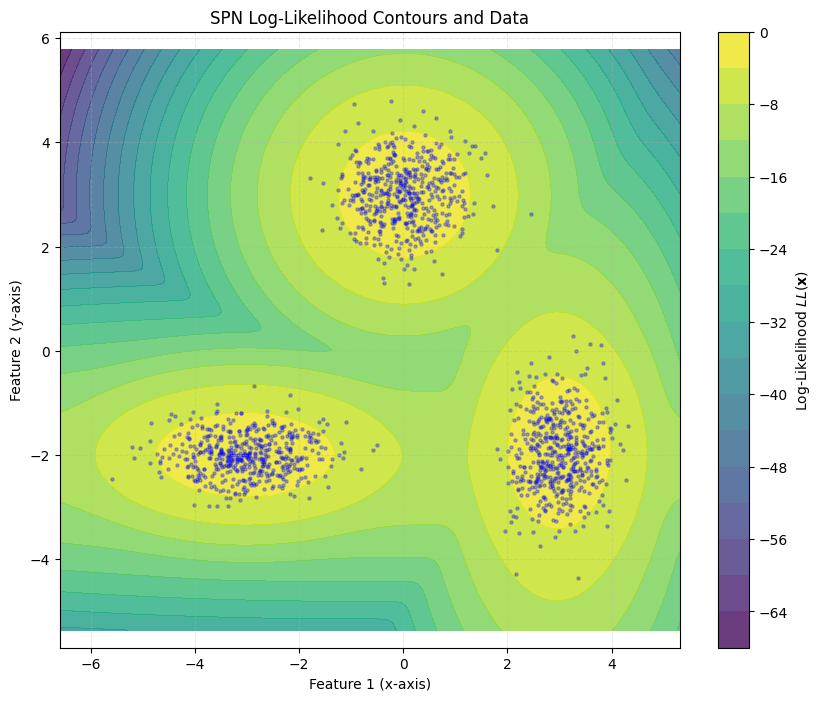

In [6]:
import numpy as np
data_np = dataset.cpu().numpy()

# Define the boundaries of the plot with a small padding
x_min, x_max = data_np[:, 0].min() - 1, data_np[:, 0].max() + 1
y_min, y_max = data_np[:, 1].min() - 1, data_np[:, 1].max() + 1

# Create a grid of points
grid_resolution = 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_resolution),
                     np.linspace(y_min, y_max, grid_resolution))

# Stack the grid points into a format our function can accept: [n_points, 2]
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
ll = log_likelihood(spn, grid_points)
# Reshape the LL values to match the grid shape for plotting
Z = ll.detach().cpu().numpy().reshape(xx.shape)


# --- 6. Visualize the Data and Log-Likelihood Contours ---

plt.figure(figsize=(10, 8))

# Plot the filled contour map of the log-likelihood
# Higher values (brighter colors) mean the model thinks data is more likely there
contour = plt.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.8)

# Add a color bar to show the LL scale
plt.colorbar(contour, label='Log-Likelihood $LL(\mathbf{x})$')

# Overlay the scatter plot of the actual data points
# We make them semi-transparent and small to see the density and contours
plt.scatter(data_np[:, 0], data_np[:, 1], s=5, alpha=0.3, c='blue')

# Add titles and labels
plt.title('SPN Log-Likelihood Contours and Data')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.show()


## Automatic Model creation
Besides creating an SPN manually by stacking layers, it is also possible to use algorithms to automatically construct the SPN architecture.

###  Rat-SPN
The Rat-SPN algorithm builds a deep network structure by recursively partitioning the features (variables) into random subsets and alternating between sum and product layers.
Below, we set up a Rat-SPN by defining its structure and parameters.

In [7]:
from spflow.modules.rat.rat_spn import RatSPN
depth = 1
n_region_nodes = 3
num_leaves = 2
num_repetitions = 2
n_root_nodes = 1
num_feature = 2

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Normal(scope=scope, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_halves=True,
)
rat

RatSPN(
  D=1, C=1, R=2
  (root_node): MixingLayer(
    D=1, C=1, R=2, weights=(1, 2, 1)
    (inputs): Sum(
      D=1, C=1, R=2, weights=(1, 4, 1, 2)
      (inputs): OuterProduct(
        D=1, C=4, R=2
        (inputs): ModuleList(
          (0): SplitHalves(
            D=2, C=2, R=2, dim=1
            (inputs): ModuleList(
              (0): Factorize(
                D=2, C=2, R=2
                (inputs): ModuleList(
                  (0): Normal(
                    D=2, C=2, R=2
                    (distribution): Normal()
                  )
                )
              )
            )
          )
        )
      )
    )
  )
)

Here is a visualization of the architecture we just created.

In [8]:
display(SVG(filename='Rat_SPN.svg'))

In [9]:
ll = log_likelihood(rat, dataset)
ll

tensor([[[-13.7532]],

        [[ -4.0741]],

        [[-14.1846]],

        ...,

        [[ -6.9775]],

        [[ -8.3973]],

        [[-12.7396]]], grad_fn=<ViewBackward0>)

We can again train this model using the provided gradient descent method.

In [10]:
train_gradient_descent(rat, dataloader, epochs=20, lr=0.1)

Time taken for epoch:  0.5850019454956055
Time taken for epoch:  0.5759990215301514
Time taken for epoch:  0.6160030364990234
Time taken for epoch:  0.5880181789398193
Time taken for epoch:  0.6010193824768066
Time taken for epoch:  0.6299965381622314
Time taken for epoch:  0.6500020027160645
Time taken for epoch:  0.7071928977966309
Time taken for epoch:  0.8330776691436768
Time taken for epoch:  0.8486034870147705
Time taken for epoch:  0.6609981060028076
Time taken for epoch:  0.685997724533081
Time taken for epoch:  0.8544025421142578
Time taken for epoch:  0.7143759727478027
Time taken for epoch:  1.0990231037139893
Time taken for epoch:  0.8099963665008545
Time taken for epoch:  0.6980230808258057
Time taken for epoch:  0.6499412059783936
Time taken for epoch:  0.6665353775024414
Time taken for epoch:  0.7449982166290283


o verify that the training worked properly, we can visualize the log-likelihoods of the trained model.

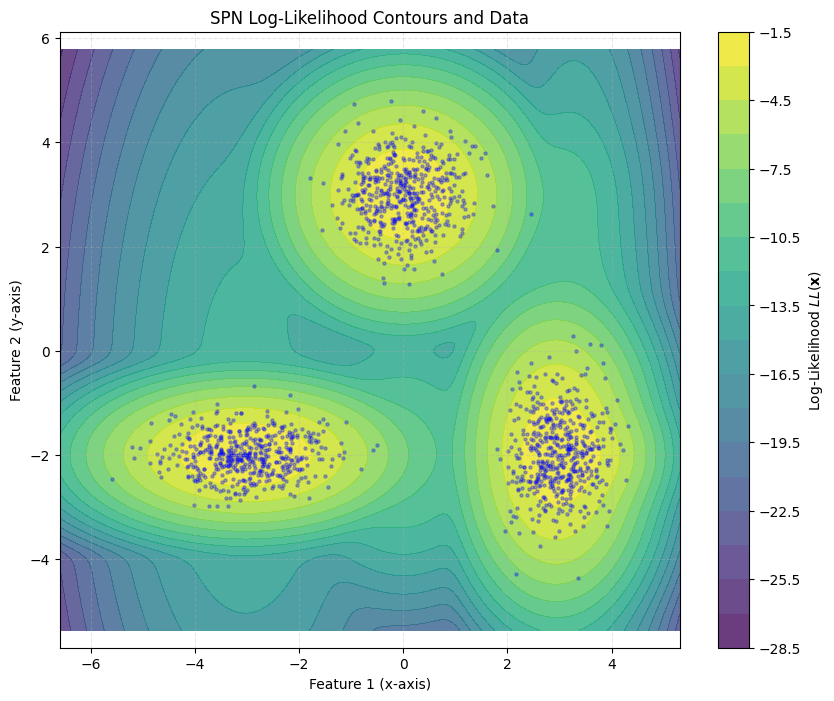

In [11]:
import numpy as np
data_np = dataset.cpu().numpy()

# Define the boundaries of the plot with a small padding
x_min, x_max = data_np[:, 0].min() - 1, data_np[:, 0].max() + 1
y_min, y_max = data_np[:, 1].min() - 1, data_np[:, 1].max() + 1

# Create a grid of points
grid_resolution = 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_resolution),
                     np.linspace(y_min, y_max, grid_resolution))

# Stack the grid points into a format our function can accept: [n_points, 2]
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
ll = log_likelihood(rat, grid_points)
# Reshape the LL values to match the grid shape for plotting
Z = ll.detach().cpu().numpy().reshape(xx.shape)


# --- 6. Visualize the Data and Log-Likelihood Contours ---

plt.figure(figsize=(10, 8))

# Plot the filled contour map of the log-likelihood
# Higher values (brighter colors) mean the model thinks data is more likely there
contour = plt.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.8)

# Add a color bar to show the LL scale
plt.colorbar(contour, label='Log-Likelihood $LL(\mathbf{x})$')

# Overlay the scatter plot of the actual data points
# We make them semi-transparent and small to see the density and contours
plt.scatter(data_np[:, 0], data_np[:, 1], s=5, alpha=0.3, c='blue')

# Add titles and labels
plt.title('SPN Log-Likelihood Contours and Data')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.show()

Of course, computing log-likelihoods is not the only thing the model can do.
Below is a visualization of samples drawn from the trained Rat-SPN.

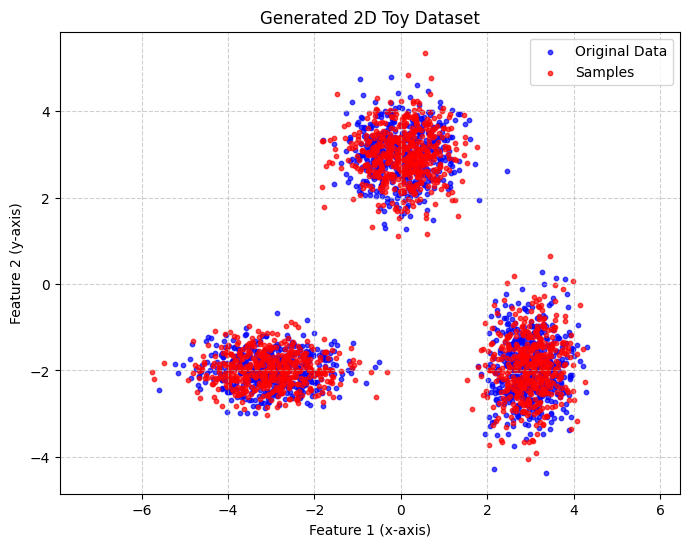

In [12]:
from spflow import sample

samples = sample(spn, 1500)

plt.figure(figsize=(8, 6))
# We use a scatter plot. data_np[:, 0] is the x-axis, data_np[:, 1] is the y-axis
plt.scatter(data_np[:, 0], data_np[:, 1], s=10, alpha=0.7, c='blue', label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.7, c='red', label='Samples')
plt.title('Generated 2D Toy Dataset')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.legend()
plt.show()


Up to now, we have focused only on generation, without considering the labels of the training instances.
Next, we will train a second Rat-SPN for classification.

In [13]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s"
)

depth = 1
n_region_nodes = 1
num_leaves = 10
num_repetitions = 1
n_root_nodes = 3
num_feature = 2

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Normal(scope=scope, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_halves=True,
)
train_dataset = TensorDataset(dataset, labels)
dataloader_with_labels = DataLoader(train_dataset, batch_size=10)

train_gradient_descent(rat.root_node.inputs, dataloader_with_labels, epochs=100, lr=0.001, is_classification=True, verbose=True)



2025-10-16 16:21:04,181 [INFO] spflow.learn.gradient_descent: Epoch [0/100]: Loss: 8.747356414794922


Time taken for epoch:  0.7879989147186279
Accuracy: 39.13333333333333


2025-10-16 16:21:04,894 [INFO] spflow.learn.gradient_descent: Epoch [1/100]: Loss: 7.447380065917969


Time taken for epoch:  0.7115383148193359
Accuracy: 81.33333333333333


2025-10-16 16:21:05,622 [INFO] spflow.learn.gradient_descent: Epoch [2/100]: Loss: 6.258777141571045


Time taken for epoch:  0.7270607948303223
Accuracy: 92.26666666666667


2025-10-16 16:21:06,311 [INFO] spflow.learn.gradient_descent: Epoch [3/100]: Loss: 5.308655738830566


Time taken for epoch:  0.6880025863647461
Accuracy: 97.93333333333334


2025-10-16 16:21:06,923 [INFO] spflow.learn.gradient_descent: Epoch [4/100]: Loss: 4.665619373321533


Time taken for epoch:  0.6091146469116211
Accuracy: 98.66666666666667


2025-10-16 16:21:07,500 [INFO] spflow.learn.gradient_descent: Epoch [5/100]: Loss: 4.217600345611572


Time taken for epoch:  0.574566125869751
Accuracy: 99.13333333333334


2025-10-16 16:21:08,007 [INFO] spflow.learn.gradient_descent: Epoch [6/100]: Loss: 3.889824628829956


Time taken for epoch:  0.5060000419616699
Accuracy: 99.4


2025-10-16 16:21:08,470 [INFO] spflow.learn.gradient_descent: Epoch [7/100]: Loss: 3.6392006874084473


Time taken for epoch:  0.46152257919311523
Accuracy: 99.66666666666667


2025-10-16 16:21:08,944 [INFO] spflow.learn.gradient_descent: Epoch [8/100]: Loss: 3.438681125640869


Time taken for epoch:  0.47400426864624023
Accuracy: 99.73333333333333


2025-10-16 16:21:09,351 [INFO] spflow.learn.gradient_descent: Epoch [9/100]: Loss: 3.2675483226776123


Time taken for epoch:  0.40505433082580566
Accuracy: 99.73333333333333


2025-10-16 16:21:09,766 [INFO] spflow.learn.gradient_descent: Epoch [10/100]: Loss: 3.111802577972412


Time taken for epoch:  0.41404080390930176
Accuracy: 99.8


2025-10-16 16:21:10,230 [INFO] spflow.learn.gradient_descent: Epoch [11/100]: Loss: 2.9685637950897217


Time taken for epoch:  0.463087797164917
Accuracy: 99.8


2025-10-16 16:21:10,695 [INFO] spflow.learn.gradient_descent: Epoch [12/100]: Loss: 2.839931011199951


Time taken for epoch:  0.4641880989074707
Accuracy: 99.73333333333333


2025-10-16 16:21:11,225 [INFO] spflow.learn.gradient_descent: Epoch [13/100]: Loss: 2.7265613079071045


Time taken for epoch:  0.5279998779296875
Accuracy: 99.73333333333333


2025-10-16 16:21:11,687 [INFO] spflow.learn.gradient_descent: Epoch [14/100]: Loss: 2.6281096935272217


Time taken for epoch:  0.4605133533477783
Accuracy: 99.73333333333333


2025-10-16 16:21:12,169 [INFO] spflow.learn.gradient_descent: Epoch [15/100]: Loss: 2.543609857559204


Time taken for epoch:  0.48051953315734863
Accuracy: 99.73333333333333


2025-10-16 16:21:12,568 [INFO] spflow.learn.gradient_descent: Epoch [16/100]: Loss: 2.4712281227111816


Time taken for epoch:  0.3975231647491455
Accuracy: 99.73333333333333


2025-10-16 16:21:12,975 [INFO] spflow.learn.gradient_descent: Epoch [17/100]: Loss: 2.4087488651275635


Time taken for epoch:  0.4055154323577881
Accuracy: 99.73333333333333


2025-10-16 16:21:13,357 [INFO] spflow.learn.gradient_descent: Epoch [18/100]: Loss: 2.3542284965515137


Time taken for epoch:  0.3809990882873535
Accuracy: 99.73333333333333


2025-10-16 16:21:13,776 [INFO] spflow.learn.gradient_descent: Epoch [19/100]: Loss: 2.3061914443969727


Time taken for epoch:  0.418515682220459
Accuracy: 99.73333333333333


2025-10-16 16:21:14,210 [INFO] spflow.learn.gradient_descent: Epoch [20/100]: Loss: 2.2635550498962402


Time taken for epoch:  0.43151235580444336
Accuracy: 99.73333333333333


2025-10-16 16:21:14,618 [INFO] spflow.learn.gradient_descent: Epoch [21/100]: Loss: 2.2255189418792725


Time taken for epoch:  0.40752458572387695
Accuracy: 99.8


2025-10-16 16:21:15,041 [INFO] spflow.learn.gradient_descent: Epoch [22/100]: Loss: 2.1914806365966797


Time taken for epoch:  0.42104196548461914
Accuracy: 99.8


2025-10-16 16:21:15,512 [INFO] spflow.learn.gradient_descent: Epoch [23/100]: Loss: 2.16097092628479


Time taken for epoch:  0.4690589904785156
Accuracy: 99.8


2025-10-16 16:21:15,955 [INFO] spflow.learn.gradient_descent: Epoch [24/100]: Loss: 2.1335997581481934


Time taken for epoch:  0.44109320640563965
Accuracy: 99.8


2025-10-16 16:21:16,413 [INFO] spflow.learn.gradient_descent: Epoch [25/100]: Loss: 2.1090292930603027


Time taken for epoch:  0.45703673362731934
Accuracy: 99.8


2025-10-16 16:21:16,888 [INFO] spflow.learn.gradient_descent: Epoch [26/100]: Loss: 2.0869503021240234


Time taken for epoch:  0.4745171070098877
Accuracy: 99.86666666666666


2025-10-16 16:21:17,309 [INFO] spflow.learn.gradient_descent: Epoch [27/100]: Loss: 2.0670790672302246


Time taken for epoch:  0.41900086402893066
Accuracy: 99.86666666666666


2025-10-16 16:21:17,774 [INFO] spflow.learn.gradient_descent: Epoch [28/100]: Loss: 2.0491578578948975


Time taken for epoch:  0.4649968147277832
Accuracy: 99.86666666666666


2025-10-16 16:21:18,202 [INFO] spflow.learn.gradient_descent: Epoch [29/100]: Loss: 2.0329604148864746


Time taken for epoch:  0.4265279769897461
Accuracy: 99.86666666666666


2025-10-16 16:21:18,622 [INFO] spflow.learn.gradient_descent: Epoch [30/100]: Loss: 2.0182909965515137


Time taken for epoch:  0.4195263385772705
Accuracy: 99.86666666666666


2025-10-16 16:21:19,050 [INFO] spflow.learn.gradient_descent: Epoch [31/100]: Loss: 2.0049843788146973


Time taken for epoch:  0.42604947090148926
Accuracy: 99.86666666666666


2025-10-16 16:21:19,433 [INFO] spflow.learn.gradient_descent: Epoch [32/100]: Loss: 1.9929012060165405


Time taken for epoch:  0.38199925422668457
Accuracy: 99.93333333333334


2025-10-16 16:21:19,966 [INFO] spflow.learn.gradient_descent: Epoch [33/100]: Loss: 1.9819233417510986


Time taken for epoch:  0.531564474105835
Accuracy: 99.93333333333334


2025-10-16 16:21:20,377 [INFO] spflow.learn.gradient_descent: Epoch [34/100]: Loss: 1.971950888633728


Time taken for epoch:  0.4100000858306885
Accuracy: 99.93333333333334


2025-10-16 16:21:20,754 [INFO] spflow.learn.gradient_descent: Epoch [35/100]: Loss: 1.9628970623016357


Time taken for epoch:  0.3749988079071045
Accuracy: 100.0


2025-10-16 16:21:21,143 [INFO] spflow.learn.gradient_descent: Epoch [36/100]: Loss: 1.9546836614608765


Time taken for epoch:  0.3880023956298828
Accuracy: 100.0


2025-10-16 16:21:21,536 [INFO] spflow.learn.gradient_descent: Epoch [37/100]: Loss: 1.9472417831420898


Time taken for epoch:  0.3915257453918457
Accuracy: 100.0


2025-10-16 16:21:21,944 [INFO] spflow.learn.gradient_descent: Epoch [38/100]: Loss: 1.9405062198638916


Time taken for epoch:  0.40700316429138184
Accuracy: 100.0


2025-10-16 16:21:22,349 [INFO] spflow.learn.gradient_descent: Epoch [39/100]: Loss: 1.9344186782836914


Time taken for epoch:  0.4029994010925293
Accuracy: 100.0


2025-10-16 16:21:22,736 [INFO] spflow.learn.gradient_descent: Epoch [40/100]: Loss: 1.9289239645004272


Time taken for epoch:  0.3859999179840088
Accuracy: 100.0


2025-10-16 16:21:23,130 [INFO] spflow.learn.gradient_descent: Epoch [41/100]: Loss: 1.9239723682403564


Time taken for epoch:  0.391998291015625
Accuracy: 100.0


2025-10-16 16:21:23,502 [INFO] spflow.learn.gradient_descent: Epoch [42/100]: Loss: 1.91951584815979


Time taken for epoch:  0.37000012397766113
Accuracy: 100.0


2025-10-16 16:21:23,874 [INFO] spflow.learn.gradient_descent: Epoch [43/100]: Loss: 1.9155099391937256


Time taken for epoch:  0.37200164794921875
Accuracy: 100.0


2025-10-16 16:21:24,246 [INFO] spflow.learn.gradient_descent: Epoch [44/100]: Loss: 1.9119163751602173


Time taken for epoch:  0.3709986209869385
Accuracy: 100.0


2025-10-16 16:21:24,661 [INFO] spflow.learn.gradient_descent: Epoch [45/100]: Loss: 1.9086980819702148


Time taken for epoch:  0.41300392150878906
Accuracy: 100.0


2025-10-16 16:21:25,119 [INFO] spflow.learn.gradient_descent: Epoch [46/100]: Loss: 1.9058212041854858


Time taken for epoch:  0.4561283588409424
Accuracy: 100.0


2025-10-16 16:21:25,655 [INFO] spflow.learn.gradient_descent: Epoch [47/100]: Loss: 1.9032554626464844


Time taken for epoch:  0.5350472927093506
Accuracy: 100.0


2025-10-16 16:21:26,124 [INFO] spflow.learn.gradient_descent: Epoch [48/100]: Loss: 1.9009733200073242


Time taken for epoch:  0.46799802780151367
Accuracy: 100.0


2025-10-16 16:21:26,660 [INFO] spflow.learn.gradient_descent: Epoch [49/100]: Loss: 1.898950219154358


Time taken for epoch:  0.5329990386962891
Accuracy: 100.0


2025-10-16 16:21:27,096 [INFO] spflow.learn.gradient_descent: Epoch [50/100]: Loss: 1.8986889123916626


Time taken for epoch:  0.4340360164642334
Accuracy: 100.0


2025-10-16 16:21:27,578 [INFO] spflow.learn.gradient_descent: Epoch [51/100]: Loss: 1.8985944986343384


Time taken for epoch:  0.480527400970459
Accuracy: 100.0


2025-10-16 16:21:28,033 [INFO] spflow.learn.gradient_descent: Epoch [52/100]: Loss: 1.898491621017456


Time taken for epoch:  0.45399928092956543
Accuracy: 100.0


2025-10-16 16:21:28,522 [INFO] spflow.learn.gradient_descent: Epoch [53/100]: Loss: 1.8983796834945679


Time taken for epoch:  0.4870009422302246
Accuracy: 100.0


2025-10-16 16:21:29,070 [INFO] spflow.learn.gradient_descent: Epoch [54/100]: Loss: 1.8982595205307007


Time taken for epoch:  0.5470764636993408
Accuracy: 100.0


2025-10-16 16:21:29,566 [INFO] spflow.learn.gradient_descent: Epoch [55/100]: Loss: 1.8981313705444336


Time taken for epoch:  0.495086669921875
Accuracy: 100.0


2025-10-16 16:21:29,961 [INFO] spflow.learn.gradient_descent: Epoch [56/100]: Loss: 1.897996187210083


Time taken for epoch:  0.3940010070800781
Accuracy: 100.0


2025-10-16 16:21:30,344 [INFO] spflow.learn.gradient_descent: Epoch [57/100]: Loss: 1.8978526592254639


Time taken for epoch:  0.382000207901001
Accuracy: 100.0


2025-10-16 16:21:30,706 [INFO] spflow.learn.gradient_descent: Epoch [58/100]: Loss: 1.897703766822815


Time taken for epoch:  0.3599998950958252
Accuracy: 100.0


2025-10-16 16:21:31,081 [INFO] spflow.learn.gradient_descent: Epoch [59/100]: Loss: 1.8975483179092407


Time taken for epoch:  0.3730001449584961
Accuracy: 100.0


2025-10-16 16:21:31,475 [INFO] spflow.learn.gradient_descent: Epoch [60/100]: Loss: 1.8973872661590576


Time taken for epoch:  0.39299988746643066
Accuracy: 100.0


2025-10-16 16:21:31,863 [INFO] spflow.learn.gradient_descent: Epoch [61/100]: Loss: 1.8972209692001343


Time taken for epoch:  0.3859987258911133
Accuracy: 100.0


2025-10-16 16:21:32,252 [INFO] spflow.learn.gradient_descent: Epoch [62/100]: Loss: 1.897050142288208


Time taken for epoch:  0.38800048828125
Accuracy: 100.0


2025-10-16 16:21:32,656 [INFO] spflow.learn.gradient_descent: Epoch [63/100]: Loss: 1.896875023841858


Time taken for epoch:  0.40199995040893555
Accuracy: 100.0


2025-10-16 16:21:33,106 [INFO] spflow.learn.gradient_descent: Epoch [64/100]: Loss: 1.89669668674469


Time taken for epoch:  0.44899845123291016
Accuracy: 100.0


2025-10-16 16:21:33,552 [INFO] spflow.learn.gradient_descent: Epoch [65/100]: Loss: 1.8965156078338623


Time taken for epoch:  0.44500088691711426
Accuracy: 100.0


2025-10-16 16:21:34,003 [INFO] spflow.learn.gradient_descent: Epoch [66/100]: Loss: 1.896331548690796


Time taken for epoch:  0.44951605796813965
Accuracy: 100.0


2025-10-16 16:21:34,431 [INFO] spflow.learn.gradient_descent: Epoch [67/100]: Loss: 1.8961461782455444


Time taken for epoch:  0.4270000457763672
Accuracy: 100.0


2025-10-16 16:21:34,832 [INFO] spflow.learn.gradient_descent: Epoch [68/100]: Loss: 1.8959592580795288


Time taken for epoch:  0.39999985694885254
Accuracy: 100.0


2025-10-16 16:21:35,234 [INFO] spflow.learn.gradient_descent: Epoch [69/100]: Loss: 1.8957710266113281


Time taken for epoch:  0.4015209674835205
Accuracy: 100.0


2025-10-16 16:21:35,658 [INFO] spflow.learn.gradient_descent: Epoch [70/100]: Loss: 1.8955819606781006


Time taken for epoch:  0.42252063751220703
Accuracy: 100.0


2025-10-16 16:21:36,036 [INFO] spflow.learn.gradient_descent: Epoch [71/100]: Loss: 1.8953930139541626


Time taken for epoch:  0.37600111961364746
Accuracy: 100.0


2025-10-16 16:21:36,444 [INFO] spflow.learn.gradient_descent: Epoch [72/100]: Loss: 1.8952041864395142


Time taken for epoch:  0.40599966049194336
Accuracy: 100.0


2025-10-16 16:21:36,848 [INFO] spflow.learn.gradient_descent: Epoch [73/100]: Loss: 1.895016074180603


Time taken for epoch:  0.40199899673461914
Accuracy: 100.0


2025-10-16 16:21:37,304 [INFO] spflow.learn.gradient_descent: Epoch [74/100]: Loss: 1.8948285579681396


Time taken for epoch:  0.45399975776672363
Accuracy: 100.0


2025-10-16 16:21:37,757 [INFO] spflow.learn.gradient_descent: Epoch [75/100]: Loss: 1.894793152809143


Time taken for epoch:  0.4535181522369385
Accuracy: 100.0


2025-10-16 16:21:38,200 [INFO] spflow.learn.gradient_descent: Epoch [76/100]: Loss: 1.8947750329971313


Time taken for epoch:  0.441997766494751
Accuracy: 100.0


2025-10-16 16:21:38,611 [INFO] spflow.learn.gradient_descent: Epoch [77/100]: Loss: 1.8947569131851196


Time taken for epoch:  0.40900158882141113
Accuracy: 100.0


2025-10-16 16:21:39,055 [INFO] spflow.learn.gradient_descent: Epoch [78/100]: Loss: 1.8947376012802124


Time taken for epoch:  0.44299983978271484
Accuracy: 100.0


2025-10-16 16:21:39,476 [INFO] spflow.learn.gradient_descent: Epoch [79/100]: Loss: 1.894718885421753


Time taken for epoch:  0.4200007915496826
Accuracy: 100.0


2025-10-16 16:21:39,880 [INFO] spflow.learn.gradient_descent: Epoch [80/100]: Loss: 1.8946996927261353


Time taken for epoch:  0.4030487537384033
Accuracy: 100.0


2025-10-16 16:21:40,307 [INFO] spflow.learn.gradient_descent: Epoch [81/100]: Loss: 1.8946807384490967


Time taken for epoch:  0.4249999523162842
Accuracy: 100.0


2025-10-16 16:21:40,716 [INFO] spflow.learn.gradient_descent: Epoch [82/100]: Loss: 1.8946609497070312


Time taken for epoch:  0.4085226058959961
Accuracy: 100.0


2025-10-16 16:21:41,129 [INFO] spflow.learn.gradient_descent: Epoch [83/100]: Loss: 1.8946418762207031


Time taken for epoch:  0.41252851486206055
Accuracy: 100.0


2025-10-16 16:21:41,536 [INFO] spflow.learn.gradient_descent: Epoch [84/100]: Loss: 1.8946222066879272


Time taken for epoch:  0.40604496002197266
Accuracy: 100.0


2025-10-16 16:21:41,918 [INFO] spflow.learn.gradient_descent: Epoch [85/100]: Loss: 1.8946025371551514


Time taken for epoch:  0.3809998035430908
Accuracy: 100.0


2025-10-16 16:21:42,352 [INFO] spflow.learn.gradient_descent: Epoch [86/100]: Loss: 1.8945823907852173


Time taken for epoch:  0.4330017566680908
Accuracy: 100.0


2025-10-16 16:21:42,766 [INFO] spflow.learn.gradient_descent: Epoch [87/100]: Loss: 1.8945629596710205


Time taken for epoch:  0.41299986839294434
Accuracy: 100.0


2025-10-16 16:21:43,159 [INFO] spflow.learn.gradient_descent: Epoch [88/100]: Loss: 1.8945430517196655


Time taken for epoch:  0.39099979400634766
Accuracy: 100.0


2025-10-16 16:21:43,525 [INFO] spflow.learn.gradient_descent: Epoch [89/100]: Loss: 1.8945232629776


Time taken for epoch:  0.3639988899230957
Accuracy: 100.0


2025-10-16 16:21:43,899 [INFO] spflow.learn.gradient_descent: Epoch [90/100]: Loss: 1.8945035934448242


Time taken for epoch:  0.3729977607727051
Accuracy: 100.0


2025-10-16 16:21:44,266 [INFO] spflow.learn.gradient_descent: Epoch [91/100]: Loss: 1.8944838047027588


Time taken for epoch:  0.3660013675689697
Accuracy: 100.0


2025-10-16 16:21:44,650 [INFO] spflow.learn.gradient_descent: Epoch [92/100]: Loss: 1.8944635391235352


Time taken for epoch:  0.3829989433288574
Accuracy: 100.0


2025-10-16 16:21:45,045 [INFO] spflow.learn.gradient_descent: Epoch [93/100]: Loss: 1.8944437503814697


Time taken for epoch:  0.39400291442871094
Accuracy: 100.0


2025-10-16 16:21:45,536 [INFO] spflow.learn.gradient_descent: Epoch [94/100]: Loss: 1.8944237232208252


Time taken for epoch:  0.4890010356903076
Accuracy: 100.0


2025-10-16 16:21:45,947 [INFO] spflow.learn.gradient_descent: Epoch [95/100]: Loss: 1.8944041728973389


Time taken for epoch:  0.4100534915924072
Accuracy: 100.0


2025-10-16 16:21:46,333 [INFO] spflow.learn.gradient_descent: Epoch [96/100]: Loss: 1.8943837881088257


Time taken for epoch:  0.3849985599517822
Accuracy: 100.0


2025-10-16 16:21:46,722 [INFO] spflow.learn.gradient_descent: Epoch [97/100]: Loss: 1.8943641185760498


Time taken for epoch:  0.3879983425140381
Accuracy: 100.0


2025-10-16 16:21:47,114 [INFO] spflow.learn.gradient_descent: Epoch [98/100]: Loss: 1.8943443298339844


Time taken for epoch:  0.39099907875061035
Accuracy: 100.0


2025-10-16 16:21:47,488 [INFO] spflow.learn.gradient_descent: Epoch [99/100]: Loss: 1.894324541091919


Time taken for epoch:  0.37104177474975586
Accuracy: 100.0


With this SPN, we can now draw samples based on its labels. 

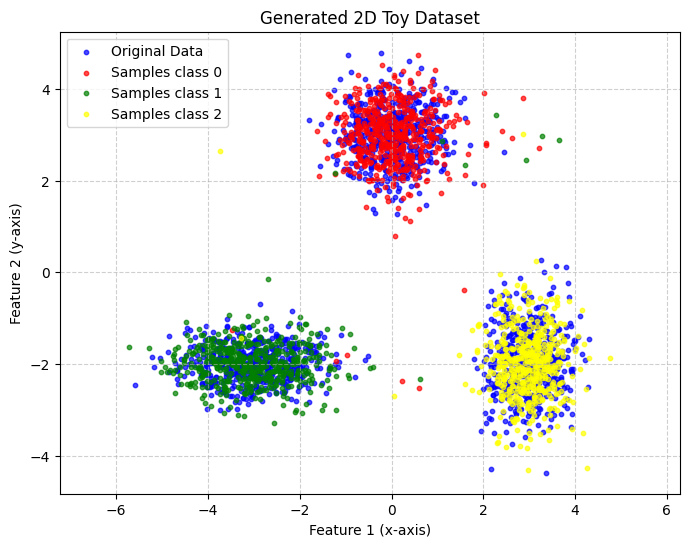

In [14]:
from spflow.meta.dispatch import SamplingContext

n_samples = 500
out_features = rat.out_features
num_features = 2

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 0, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class0 = sample(rat, evidence, sampling_ctx=sampling_ctx)

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 1, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class1 = sample(rat, evidence, sampling_ctx=sampling_ctx)

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 2, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class2 = sample(rat, evidence, sampling_ctx=sampling_ctx)


plt.figure(figsize=(8, 6))
# We use a scatter plot. data_np[:, 0] is the x-axis, data_np[:, 1] is the y-axis
plt.scatter(data_np[:, 0], data_np[:, 1], s=10, alpha=0.7, c='blue', label='Original Data')
plt.scatter(samples_class0[:, 0], samples_class0[:, 1], s=10, alpha=0.7, c='red', label='Samples class 0')
plt.scatter(samples_class1[:, 0], samples_class1[:, 1], s=10, alpha=0.7, c='green', label='Samples class 1')
plt.scatter(samples_class2[:, 0], samples_class2[:, 1], s=10, alpha=0.7, c='yellow', label='Samples class 2')
plt.title('Generated 2D Toy Dataset')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.legend()
plt.show()

However, the model can of course also be used for classification. As an example, we visualize the trained decision boundaries of our model

torch.Size([90000, 1, 3])
tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])


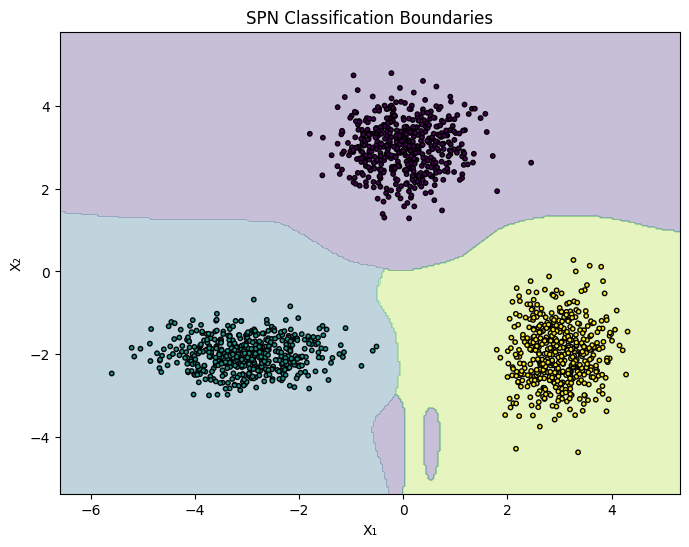

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Assuming your dataset and labels are already created as above ---

# Let's assume you have an SPN model trained on this data:
# For example:
# spn = MySPNModel()
# spn.fit(dataset, labels)

# --- 1. Create a grid of points over the feature space ---
x_min, x_max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
y_min, y_max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1

xx, yy = torch.meshgrid(
    torch.linspace(x_min, x_max, 300),
    torch.linspace(y_min, y_max, 300),
    indexing='xy'
)
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# --- 2. Get SPN predictions (probabilities or class scores) ---
# Example: if your SPN returns class probabilities
with torch.no_grad():
    probs = log_likelihood(rat.root_node.inputs, grid_points) # shape: [N_grid, num_classes]
    print(probs.shape)
    preds = probs.argmax(dim=-1)
    print(preds)

# --- 3. Reshape predictions to match the grid ---
Z = preds.reshape(xx.shape)

# --- 4. Plot decision boundaries ---
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=len(means), cmap="viridis")

# Plot the original data
plt.scatter(dataset[:, 0], dataset[:, 1], c=labels, cmap="viridis", s=10, edgecolor="k")

plt.title("SPN Classification Boundaries")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.show()


## LearnSPN
Instead of creating a random structure, we can also train the SPN structure using the LearnSPN. 

In [16]:
from spflow.learn.learn_spn import learn_spn
scope = Scope(list(range(2)))
normal_layer = Normal(scope=scope, out_channels=4)
learn_spn = learn_spn(
    torch.tensor(dataset, dtype=torch.float32),
    leaf_modules=normal_layer,
    out_channels=1,
    min_instances_slice=70,
    min_features_slice = 2
)
learn_spn

used 5 iterations (0.004s) to cluster 1500 items into 2 clusters
used 4 iterations (0.003s) to cluster 1000 items into 2 clusters


C:\Users\alex_\AppData\Local\Temp\ipykernel_24656\3209010222.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(dataset, dtype=torch.float32),
F:\Pycharm\PycharmProjects\SPFlowTorch\spflow\learn\learn_spn.py:366: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  weights = torch.tensor(w).T.unsqueeze(0).unsqueeze(-1)  # shape(1, num_clusters, 1)


Sum(
  D=1, C=1, R=None, weights=(1, 5, 1)
  (inputs): Cat(
    D=1, C=5, R=None, dim=2
    (inputs): ModuleList(
      (0): Product(
        D=1, C=4, R=None
        (inputs): Cat(
          D=2, C=4, R=None, dim=1
          (inputs): ModuleList(
            (0-1): 2 x Normal(
              D=1, C=4, R=None
              (distribution): Normal()
            )
          )
        )
      )
      (1): Sum(
        D=1, C=1, R=None, weights=(1, 8, 1)
        (inputs): Cat(
          D=1, C=8, R=None, dim=2
          (inputs): ModuleList(
            (0-1): 2 x Product(
              D=1, C=4, R=None
              (inputs): Cat(
                D=2, C=4, R=None, dim=1
                (inputs): ModuleList(
                  (0-1): 2 x Normal(
                    D=1, C=4, R=None
                    (distribution): Normal()
                  )
                )
              )
            )
          )
        )
      )
    )
  )
)

The trained SPN can now be used just like any other module

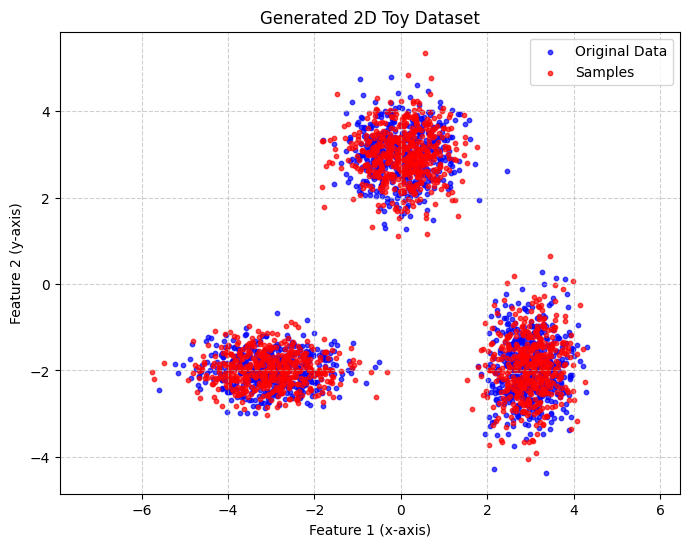

In [17]:
learn_spn_samples = sample(spn, 1500)

plt.figure(figsize=(8, 6))
# We use a scatter plot. data_np[:, 0] is the x-axis, data_np[:, 1] is the y-axis
plt.scatter(data_np[:, 0], data_np[:, 1], s=10, alpha=0.7, c='blue', label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.7, c='red', label='Samples')
plt.title('Generated 2D Toy Dataset')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.legend()
plt.show()